In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0125.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0223.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0030.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0141.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0226.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0203.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0048.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0070.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0212.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0002.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0150.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0025.jpeg
/kaggle/input/car-damage-detection/cars/data1a/validation/00-dam

In [9]:
!pip install --upgrade imutils

In [16]:
from tensorflow.keras.preprocessing. image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [25]:

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-5
EPOCHS = 50
BS = 64

DIRECTORY = r"../input/car-damage-detection/data1a/training/"
DIRECTORY2=r"../input/car-damage-detection/data1a/validation/"
CATEGORIES = ["00-damage", "01-whole"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)


for category in CATEGORIES:
    path = os.path.join(DIRECTORY2, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)
       
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)



(trainX, testX, trainY, testY) = train_test_split(data, labels,
test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
rotation_range=20,
zoom_range=0.15,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest")

[INFO] loading images...


In [26]:
baseModel =MobileNetV2 (weights="imagenet", include_top=False, input_tensor=Input (shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
#the base model
headModel= baseModel.output 
headModel= MaxPooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel) 
headModel= Dropout(0.5)(headModel) 
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become # the actual model we will train) 
model=Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will # not be updated during the first training process

9406464/9406464 [==============================] - 0s 0us/step


In [28]:
for layer in baseModel.layers:
    layer.trainable = False
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR)
model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])

print("[INFO]training head...")
H= model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX)//BS,
    validation_data=(testX,testY),
    validation_steps=len(testX)//BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO]training head...
Epoch 1/50
28/28 [==============================] - 36s 914ms/step - loss: 1.1022 - accuracy: 0.7179 - val_loss: 0.3524 - val_accuracy: 0.8630
Epoch 2/50
28/28 [==============================] - 23s 825ms/step - loss: 0.4370 - accuracy: 0.7956 - val_loss: 0.3578 - val_accuracy: 0.8435
Epoch 3/50
28/28 [==============================] - 23s 820ms/step - loss: 0.3924 - accuracy: 0.8356 - val_loss: 0.2668 - val_accuracy: 0.8870
Epoch 4/50
28/28 [==============================] - 23s 832ms/step - loss: 0.3731 - accuracy: 0.8530 - val_loss: 0.2778 - val_accuracy: 0.8783
Epoch 5/50
28/28 [==============================] - 22s 786ms/step - loss: 0.3472 - accuracy: 0.8525 - val_loss: 0.2416 - val_accuracy: 0.8891
Epoch 6/50
28/28 [==============================] - 23s 832ms/step - loss: 0.3354 - accuracy: 0.8575 - val_loss: 0.2487 - val_accuracy: 0.8913
Epoch 7/50
28/28 [==============================] - 23s 828ms/step - loss: 0.3246 - accuracy:

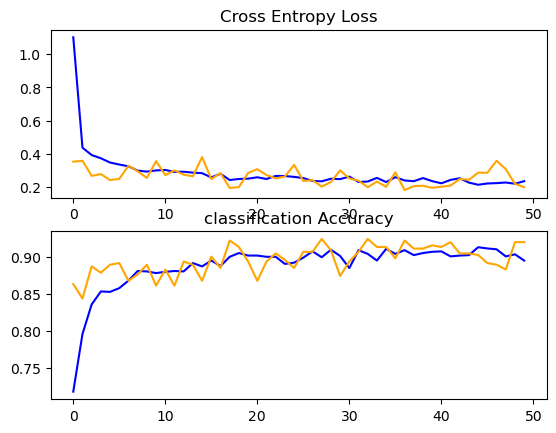

In [33]:
from  matplotlib import pyplot as plt
plt.subplot (2,1,1)
plt.title ('Cross Entropy Loss')

plt.plot(H.history['loss'],color='blue',label='train')
plt.plot(H.history['val_loss'],color ='orange',label='test')

plt.subplot(2,1,2)
plt.title('classification Accuracy')

plt.plot(H.history['accuracy'],color='blue',label='train')
plt.plot(H.history['val_accuracy'],color='orange',label='test')

plt.show()

In [ ]:
from tensorflow.keras.preprocessing. image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os